In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from keras._tf_keras.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras._tf_keras.keras import regularizers

In [4]:
DATADIR = r'./FER'
TRAIN_DIR = os.path.join(DATADIR, 'train')
TEST_DIR = os.path.join(DATADIR, 'test')
CATEGORIES = os.listdir(TRAIN_DIR)
print(CATEGORIES)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
def load_data(DATADIR, categories):
    data = []
    for category in categories:
        path = os.path.join(DATADIR, category)
        class_num = categories.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img), 0)
                data.append([img_array, class_num])
            except Exception as e:
                print(e)
    return data

# Load training and testing data
train_data = load_data(TRAIN_DIR, CATEGORIES)
test_data = load_data(TEST_DIR, CATEGORIES)

  0%|          | 0/3995 [00:00<?, ?it/s]

100%|██████████| 831/831 [00:00<00:00, 6718.34it/s]


In [9]:
# Function to preprocess the data
def preprocess_data(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X)  # No reshape needed
    X = X / 255.0  # Normalize the images
    y = np.array(y)
    y = tf.keras.utils.to_categorical(y, num_classes=len(CATEGORIES))
    return X, y

In [10]:
# Preprocess the training and testing data
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28709, 48, 48), (28709, 7), (7178, 48, 48), (7178, 7))

In [12]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

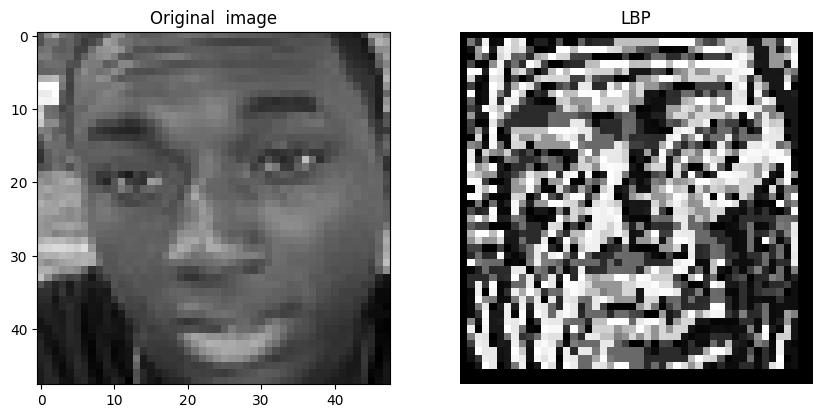

In [21]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

In [22]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [23]:
Feature_X_train = create_LBP_features(X_train)

In [24]:
Feature_X_train.shape

(28709, 48, 48)

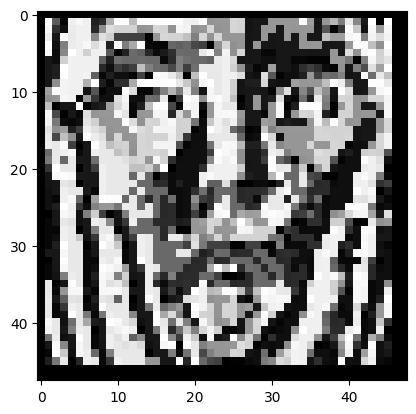

In [28]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [29]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(7178, 48, 48)

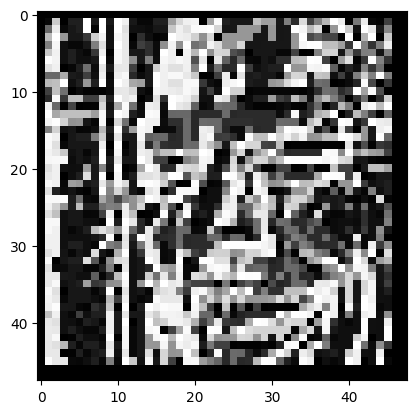

In [30]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

In [32]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CATEGORIES), activation='softmax'))

    return model


es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.000001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [33]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.2328 - loss: 2.9634 - val_accuracy: 0.2470 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 2/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.2491 - loss: 1.8174 - val_accuracy: 0.2471 - val_loss: 1.8132 - learning_rate: 0.0010
Epoch 3/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.2557 - loss: 1.8086 - val_accuracy: 0.2471 - val_loss: 1.8142 - learning_rate: 0.0010
Epoch 4/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.2532 - loss: 1.8158 - val_accuracy: 0.2471 - val_loss: 1.8137 - learning_rate: 0.0010
Epoch 5/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.2526 - loss: 1.8075 - val_accuracy: 0.2471 - val_loss: 1.8134 - learning_rate: 0.0010
Epoch 6/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.2495 - loss: 1.8120 - val_accuracy: 0.2471 - val_loss: 1.8135 - learning_rate: 0.0010
Epoch 7/50
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.25

In [35]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

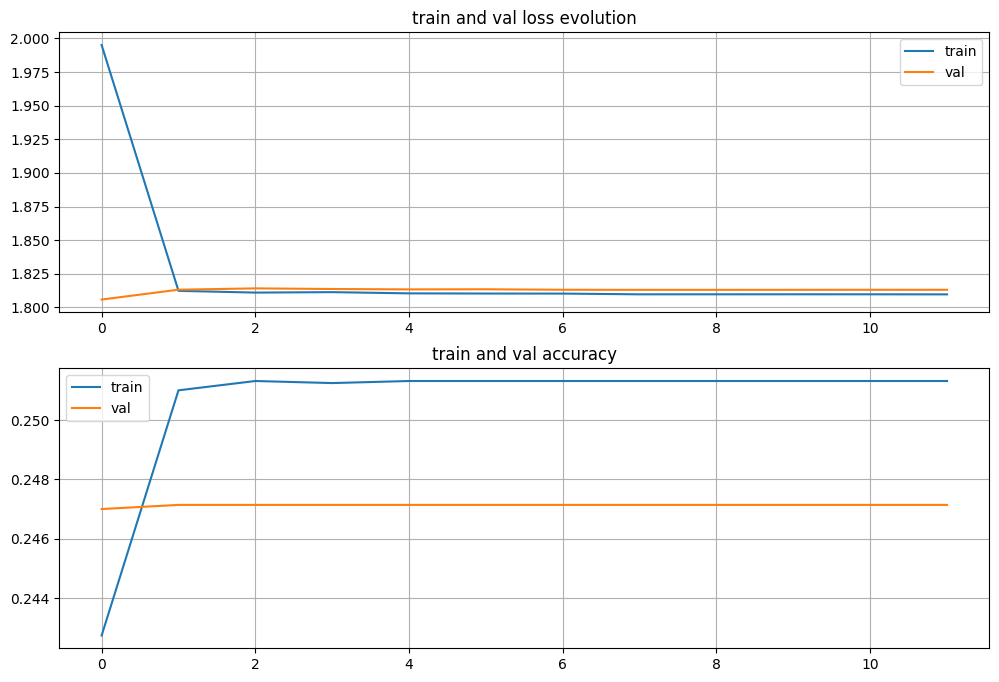

In [36]:
plot_performance(LBP_history)

In [37]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.24714405834674835


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


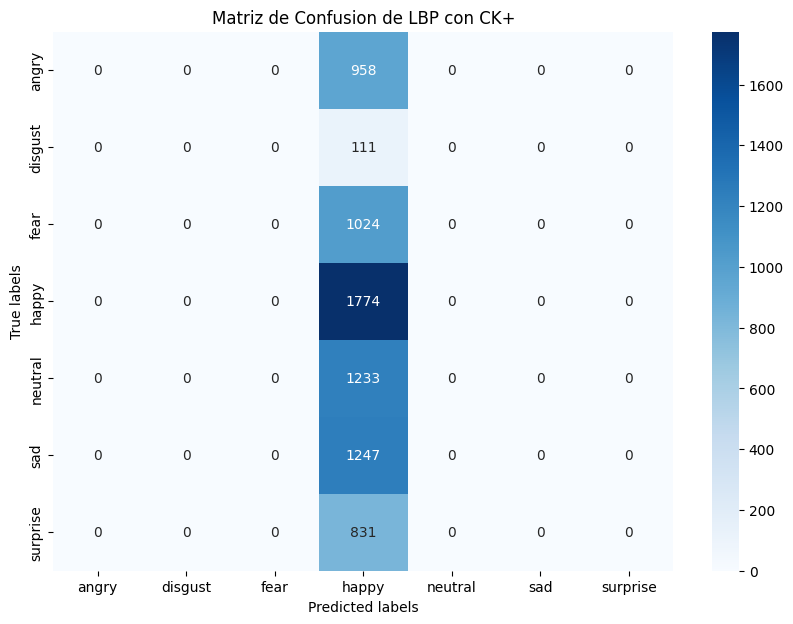

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión y el reporte de clasificación
y_pred = np.argmax(LBP_model.predict(Feature_X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_mat = confusion_matrix(y_true, y_pred)

# Crea un mapa de calor usando seaborn
plt.figure(figsize=(10, 7)) # Ajusta el tamaño de la figura
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

# Añade títulos y etiquetas
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusion de LBP con CK+')
plt.show()

In [39]:
class_report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [40]:
LBP_model.save('LBP_model_FER.h5')